# Classificação de Comentários com BERT

## 1. Instalação de dependências

In [5]:
!pip install transformers scikit-learn pandas numpy matplotlib


## 2. Importação de bibliotecas

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

## 3. Carregamento do dataset

In [7]:
from google.colab import files

uploaded = files.upload()

Saving oncas_comentarios.csv to oncas_comentarios.csv


## 4. Leitura e visualização inicial do CSV

In [8]:
CSV_NAME = "oncas_comentarios.csv"

df = pd.read_csv(CSV_NAME)

# ver as 5 primeiras linhas
df.head()


,video,onca,caseiro,fake news,ironia,notícia,Conservacionistas,comment_text
0,video0,neutro,neutro,não,sim,neutra,NaN,Solta no congresso
1,video0,neutro,neutro,não,não,boa,NaN,"vídeo direto, respeitoso, sem sensacionalismo ..."
2,video0,neutro,neutro,não,não,boa,NaN,Essa reportagem foi a melhor parabéns
3,video0,neutro,negativo,não,não,neutra,NaN,As patas 🐾 das onças no chão foi um aviso pra ...
4,video0,neutro,negativo,não,não,neutra,NaN,Se o cara viu que onça estava rondando a casa ...


## 5. Divisão em treino, validação e teste

In [9]:
df.columns

Index(['video', 'onca', 'caseiro', 'fake news', 'ironia', 'notícia',
       'Conservacionistas', 'comment_text'],
      dtype='object')

## 6. Preparação dos dados (seleção texto + rótulo)

In [10]:
df_onca = df[['comment_text', 'onca']].copy()

# muda nome das colunas pra ficar mais simples
df_onca.rename(columns={'comment_text': 'text', 'onca': 'label'}, inplace=True)

df_onca.head()


,text,label
0,Solta no congresso,neutro
1,"vídeo direto, respeitoso, sem sensacionalismo ...",neutro
2,Essa reportagem foi a melhor parabéns,neutro
3,As patas 🐾 das onças no chão foi um aviso pra ...,neutro
4,Se o cara viu que onça estava rondando a casa ...,neutro


## 7. Limpeza dos dados

In [7]:
# remove linhas em que o texto/rótulo estejam NaN
df_onca = df_onca.dropna(subset=['text', 'label'])

# garante que o texto é string e tira espaços nas pontas
df_onca['text'] = df_onca['text'].astype(str).str.strip()

# remove linhas com texto vazio
df_onca = df_onca[df_onca['text'] != '']

# remove duplicados (mesmo texto e mesmo rótulo)
df_onca = df_onca.drop_duplicates(subset=['text', 'label'])

len(df_onca), df_onca.head()


(4498,
                                                 text   label
 0                                 Solta no congresso  neutro
 1  vídeo direto, respeitoso, sem sensacionalismo ...  neutro
 2              Essa reportagem foi a melhor parabéns  neutro
 3  As patas 🐾 das onças no chão foi um aviso pra ...  neutro
 4  Se o cara viu que onça estava rondando a casa ...  neutro)

## 8. Verificando distribuição das classes

In [8]:
df_onca['label'].value_counts()


,count
label,
neutro,3417
negativo,718
positivo,363


## 9. Mapeamento dos rótulos

In [11]:
#define a ordem das classes
unique_labels = ['negativo', 'neutro', 'positivo']

#cria dicionário label -> id
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

label2id, id2label


({'negativo': 0, 'neutro': 1, 'positivo': 2},
 {0: 'negativo', 1: 'neutro', 2: 'positivo'})

In [27]:
def preparar_dados_para_coluna(df, coluna_rotulo):
    """
    Prepara os dados (text + label_id) e divide em treino, validação e teste
    para uma coluna de rótulo: 'onca', 'caseiro' ou 'notícia'.
    """
    print(f"\n=== Preparando dados para coluna: {coluna_rotulo} ===")

    # 1) Seleciona texto + rótulo
    df_col = df[['comment_text', coluna_rotulo]].copy()
    df_col.rename(columns={'comment_text': 'text', coluna_rotulo: 'label'}, inplace=True)

    # 2) Limpeza inicial
    df_col = df_col.dropna(subset=['text', 'label'])
    df_col['text'] = df_col['text'].astype(str).str.strip()
    df_col = df_col[df_col['text'] != '']
    df_col = df_col.drop_duplicates(subset=['text', 'label'])

    # Ajuste para coluna "notícia"
    if coluna_rotulo == 'notícia':
        df_col['label'] = df_col['label'].str.lower().str.strip()
        df_col['label'] = df_col['label'].replace({
            'ruim': 'negativo',
            'boa': 'positivo',
            'neutra': 'neutro'
        })

    print("Tamanho após limpeza:", len(df_col))
    print("\nDistribuição de rótulos (texto):")
    print(df_col['label'].value_counts())

    # 3) Mapeia rótulos para números
    df_col['label_id'] = df_col['label'].map(label2id)

    # remove linhas sem label_id
    df_col = df_col.dropna(subset=['label_id'])
    df_col['label_id'] = df_col['label_id'].astype(int)

    print("\nDistribuição de rótulos (ids):")
    print(df_col['label_id'].value_counts())

    # 4) Split treino / validação / teste (70/15/15)
    from sklearn.model_selection import train_test_split

    RANDOM_STATE = 42

    train_df, temp_df = train_test_split(
        df_col,
        test_size=0.30,
        stratify=df_col['label_id'],
        random_state=RANDOM_STATE
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,  # metade do 30% = 15%
        stratify=temp_df['label_id'],
        random_state=RANDOM_STATE
    )

    print("\nTamanhos:", len(train_df), "treino  |", len(val_df), "validação  |", len(test_df), "teste")

    return train_df, val_df, test_df



In [10]:
df_onca['label_id'] = df_onca['label'].map(label2id)
df_onca.head()


,text,label,label_id
0,Solta no congresso,neutro,1
1,"vídeo direto, respeitoso, sem sensacionalismo ...",neutro,1
2,Essa reportagem foi a melhor parabéns,neutro,1
3,As patas 🐾 das onças no chão foi um aviso pra ...,neutro,1
4,Se o cara viu que onça estava rondando a casa ...,neutro,1


## 10. Divisão do dataset em treino / validação / teste

In [11]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# 1) Treino (70%) e resto (30%)
train_df, temp_df = train_test_split(
    df_onca,
    test_size=0.30,
    stratify=df_onca['label_id'],
    random_state=RANDOM_STATE
)

# 2) Validação (15%) e teste (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # metade do 30% = 15%
    stratify=temp_df['label_id'],
    random_state=RANDOM_STATE
)

len(train_df), len(val_df), len(test_df)


(3148, 675, 675)

## 11. Inferência em novos exemplos (classificação manual)

In [12]:
print("Treino:")
print(train_df['label_id'].value_counts(normalize=True))

print("\nValidação:")
print(val_df['label_id'].value_counts(normalize=True))

print("\nTeste:")
print(test_df['label_id'].value_counts(normalize=True))


Treino:
label_id
1    0.759530
0    0.159784
2    0.080686
Name: proportion, dtype: float64

Validação:
label_id
1    0.760000
0    0.158519
2    0.081481
Name: proportion, dtype: float64

Teste:
label_id
1    0.76
0    0.16
2    0.08
Name: proportion, dtype: float64


## 12. Tokenização com BERT

### 12.1. Importação das bibliotecas necessárias

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer



### 12.2. Carregando o tokenizer do BERT em ptbr


In [16]:
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

### 12.3. Testando a tokenização em um exemplo simples

In [15]:
texto_exemplo = "As onças são animais importantes para o equilíbrio ecológico."

encoded = tokenizer(
    texto_exemplo,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

encoded.keys(), encoded["input_ids"].shape, encoded["attention_mask"].shape


(KeysView({'input_ids': tensor([[  101,   510,  3185,   759,   453,  3155,  2478,   221,   146,  7901,
          17382, 22290,  9391,   119,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0, 

## 13. Criação do Dataset e DataLoaders

### 13.1. Classe NewsDataset

In [17]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["text"]
        label_id = int(row["label_id"])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_id, dtype=torch.long)
        }

        return item


### 13.2. Criando os datasets de treino/val/teste

In [18]:
MAX_LEN = 128

train_dataset = NewsDataset(train_df, tokenizer, max_len=MAX_LEN)
val_dataset   = NewsDataset(val_df, tokenizer, max_len=MAX_LEN)
test_dataset  = NewsDataset(test_df, tokenizer, max_len=MAX_LEN)

len(train_dataset), len(val_dataset), len(test_dataset)


(3148, 675, 675)

### 13.3. Criando os DataLoaders

In [19]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### 13.4. Conferindo um batch

In [20]:
batch = next(iter(train_loader))

for k, v in batch.items():
    print(k, v.shape)


input_ids torch.Size([16, 128])
attention_mask torch.Size([16, 128])
labels torch.Size([16])


## 14. Definição do modelo BERT para classificação

### 14.1. Importando o modelo pré-treinado

In [18]:
from transformers import AutoModelForSequenceClassification

num_labels = len(label2id)  #deve ser 3(negativo, neutro, positivo)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 14.2. Enviando o modelo para o dispositivo (CPU) e configurando o otimizador

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [20]:
learning_rate = 2e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


In [24]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 15. Loop de treinamento (train/val por época)

### 15.1. Função pra treinar uma época

In [21]:
def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)

        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += batch_size

    avg_loss = total_loss / total_examples
    accuracy = total_correct / total_examples

    return avg_loss, accuracy


### 15.2. Função para avaliar uma época (validação)

In [22]:
def eval_one_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            batch_size = labels.size(0)

            total_loss += loss.item() * batch_size
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_examples += batch_size

    avg_loss = total_loss / total_examples
    accuracy = total_correct / total_examples

    return avg_loss, accuracy


### 15.3. Loop principal de épocas (train + val)

In [34]:
EPOCHS = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    print("-" * 30)

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Treino    - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Validação - Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    print()


Epoch 1/10
------------------------------
Treino    - Loss: 0.0779 | Acc: 0.9781
Validação - Loss: 0.7661 | Acc: 0.7970

Epoch 2/10
------------------------------
Treino    - Loss: 0.0402 | Acc: 0.9905
Validação - Loss: 0.9311 | Acc: 0.8193

Epoch 3/10
------------------------------
Treino    - Loss: 0.0371 | Acc: 0.9882
Validação - Loss: 0.9980 | Acc: 0.8059

Epoch 4/10
------------------------------
Treino    - Loss: 0.0319 | Acc: 0.9902
Validação - Loss: 1.0063 | Acc: 0.8074

Epoch 5/10
------------------------------
Treino    - Loss: 0.0191 | Acc: 0.9952
Validação - Loss: 1.0281 | Acc: 0.8044

Epoch 6/10
------------------------------
Treino    - Loss: 0.0131 | Acc: 0.9968
Validação - Loss: 1.1269 | Acc: 0.8059

Epoch 7/10
------------------------------
Treino    - Loss: 0.0095 | Acc: 0.9987
Validação - Loss: 1.1412 | Acc: 0.8044

Epoch 8/10
------------------------------
Treino    - Loss: 0.0152 | Acc: 0.9946
Validação - Loss: 1.2198 | Acc: 0.7985

Epoch 9/10
---------------------

### 15.4 Função Geral para rodar experimento

In [13]:
from sklearn.metrics import classification_report

def rodar_experimento_para_coluna(coluna_rotulo):
    """
    Prepara dados, treina o BERT, avalia no teste e imprime métricas pra uma coluna do rotulo
    """

    # 1) Preparação dos dados (texto + label_id + splits)
    train_df, val_df, test_df = preparar_dados_para_coluna(df, coluna_rotulo)

    # 2) Criação dos Datasets e DataLoaders
    MAX_LEN = 128
    BATCH_SIZE = 16

    train_dataset = NewsDataset(train_df, tokenizer, max_len=MAX_LEN)
    val_dataset   = NewsDataset(val_df, tokenizer, max_len=MAX_LEN)
    test_dataset  = NewsDataset(test_df, tokenizer, max_len=MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 3) Criação de um novo modelo BERT para essa coluna
    num_labels = len(label2id)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # 4) Loop de treinamento (train + val)
    EPOCHS = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"\n#############################")
    print(f"Treinando coluna: {coluna_rotulo}")
    print(f"#############################\n")

    for epoch in range(1, EPOCHS + 1):
        print(f"Epoch {epoch}/{EPOCHS}")
        print("-" * 30)

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Treino    - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Validação - Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print()

    # 5) Avaliação final no conjunto de teste
    test_loss, test_acc = eval_one_epoch(model, test_loader, device)
    print(f"[{coluna_rotulo}] Teste - Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

    # 6) Classification report (precision, recall, F1)
    texts = test_df["text"].tolist()
    true_ids = test_df["label_id"].tolist()

    pred_ids = []

    model.eval()
    with torch.no_grad():
        for text in texts:
            encoding = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )

            input_ids = encoding["input_ids"].to(device)
            attention_mask = encoding["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            pred_id = logits.argmax(dim=1).item()
            pred_ids.append(pred_id)

    print("\nRelatório de classificação para a coluna:", coluna_rotulo)
    print(classification_report(
        true_ids,
        pred_ids,
        target_names=[id2label[i] for i in sorted(id2label.keys())]
    ))

    # opcional: retornar info se você quiser plotar depois
    resultados = {
        "coluna": coluna_rotulo,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

    return resultados, model


## 16. Avaliação no conjunto de teste

### 16.1. Loss e acurácia no teste

In [35]:
# aqui é feita a avaliação do modelo no conjunto de teste usando a mesma função de validação pra obter o loss e a acurácia final
test_loss, test_acc = eval_one_epoch(model, test_loader, device)

print(f"Teste - Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")


Teste - Loss: 0.9250 | Acc: 0.8237


### 16.2. Classification report (precision, recall, F1)

In [36]:
from sklearn.metrics import classification_report

texts = test_df["text"].tolist()
true_ids = test_df["label_id"].tolist()

pred_ids = []

model.eval()
with torch.no_grad():
    for text in texts:
        encoding = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        pred_id = logits.argmax(dim=1).item()
        pred_ids.append(pred_id)

print(classification_report(
    true_ids,
    pred_ids,
    target_names=[id2label[i] for i in sorted(id2label.keys())]
))


              precision    recall  f1-score   support

    negativo       0.57      0.68      0.62       108
      neutro       0.91      0.88      0.90       513
    positivo       0.57      0.57      0.57        54

    accuracy                           0.82       675
   macro avg       0.69      0.71      0.70       675
weighted avg       0.83      0.82      0.83       675



## 17. Gráfico de evolução do loss

### Loss

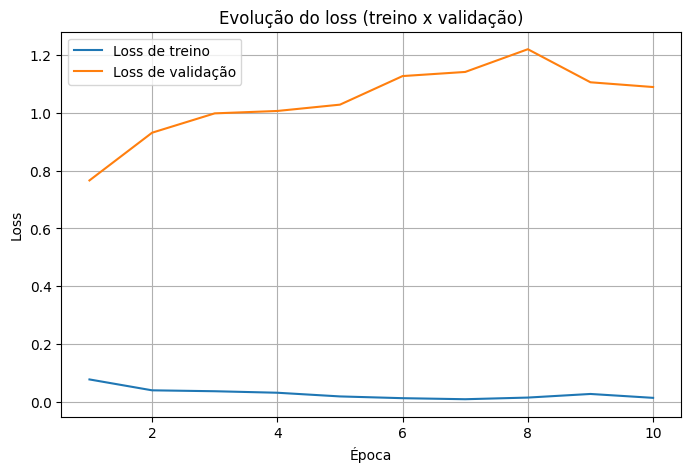

In [37]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Loss de treino")
plt.plot(epochs_range, val_losses, label="Loss de validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolução do loss (treino x validação)")
plt.legend()
plt.grid(True)
plt.show()


### Acurácia

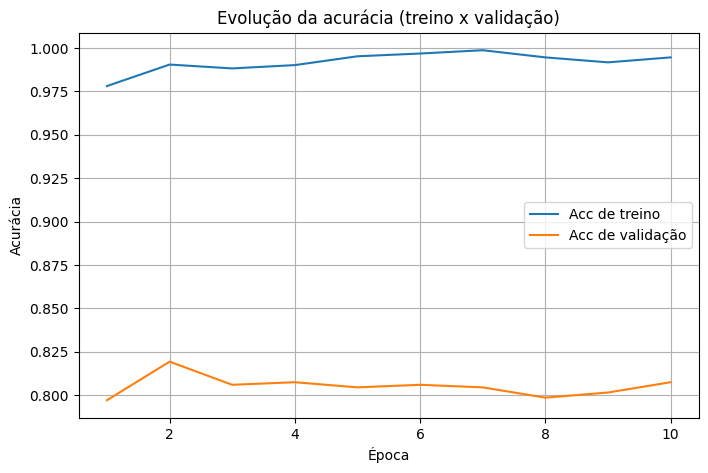

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Acc de treino")
plt.plot(epochs_range, val_accuracies, label="Acc de validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da acurácia (treino x validação)")
plt.legend()
plt.grid(True)
plt.show()


## 18. Exemplos de erros (textos classificados errado)

In [39]:
import pandas as pd

results_df = test_df.copy().reset_index(drop=True)
results_df["pred_id"] = pred_ids
results_df["true_label"] = results_df["label_id"].map(id2label)
results_df["pred_label"] = results_df["pred_id"].map(id2label)

errors_df = results_df[results_df["true_label"] != results_df["pred_label"]]

print(f"Total de erros: {len(errors_df)} de {len(results_df)} exemplos de teste.\n")

errors_df[["text", "true_label", "pred_label"]].head(10)


Total de erros: 119 de 675 exemplos de teste.



,text,true_label,pred_label
0,O ser humano foi criado pelo todo poderoso Deu...,negativo,neutro
10,A onça estudou os passos do Sr. Jorge...,negativo,neutro
12,Acredito que os incêndios do último verão pode...,positivo,neutro
17,​@@DAVI-LDI Ainda prefiro a onça,positivo,neutro
23,meu irmao ja foi atacado porem saiu vivo..tava...,negativo,neutro
24,As queimadas fez um desequilíbrio n mata n bio...,neutro,positivo
28,Linda vc 🥰🥰,neutro,positivo
29,Ótimo vídeo!<br>(Só lembrando que se fizéssemo...,neutro,negativo
36,"Não é normal oque rapaz, vai la ver o video do...",negativo,neutro
43,"Não faltou experiência, faltou vigilância, e e...",neutro,negativo


## 19. Inferência em novos exemplos (classificação manual). A célula final já apresenta todas as 3 classes
Aqui vou mostrar previsões manuais usando o modelo treinado. O objetivo é demonstrar a classificação de textos reais. A função abaixo recebe uma lista de textos, executa tokenização, passa pelo modelo BERT e retorna o rótulo previsto para cada exemplo.

In [40]:
def predict_texts(texts, model, tokenizer, max_len, device, id2label):
    model.eval()
    results = []
    with torch.no_grad():
        for text in texts:
            encoding = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )

            input_ids = encoding["input_ids"].to(device)
            attention_mask = encoding["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred_id = logits.argmax(dim=1).item()
            pred_label = id2label[pred_id]

            results.append((text, pred_label))

    return results


### Exemplos para demonstração
três textos reais que serão exibidos:

In [41]:
textos_para_teste = [
    "Essa onça é perigosa demais, tinha que capturar logo.",
    "Muito boa a forma como explicaram a importância da onça no ecossistema.",
    "Não sei o que pensar, parece algo neutro pra mim."
]

predicoes = predict_texts(textos_para_teste, model, tokenizer, MAX_LEN, device, id2label)

for texto, pred in predicoes:
    print(f"Texto: {texto}\n→ Predição: {pred}\n")


Texto: Essa onça é perigosa demais, tinha que capturar logo.
→ Predição: negativo

Texto: Muito boa a forma como explicaram a importância da onça no ecossistema.
→ Predição: neutro

Texto: Não sei o que pensar, parece algo neutro pra mim.
→ Predição: neutro



# Versão final com as classes -- onca, caseiro e noticia

In [29]:
result_onca, model_onca = rodar_experimento_para_coluna("onca")
result_caseiro, model_caseiro = rodar_experimento_para_coluna("caseiro")
result_noticia, model_noticia = rodar_experimento_para_coluna("notícia")



=== Preparando dados para coluna: onca ===
Tamanho após limpeza: 4498

Distribuição de rótulos (texto):
label
neutro      3417
negativo     718
positivo     363
Name: count, dtype: int64

Distribuição de rótulos (ids):
label_id
1    3417
0     718
2     363
Name: count, dtype: int64

Tamanhos: 3148 treino  | 675 validação  | 675 teste


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



#############################
Treinando coluna: onca
#############################

Epoch 1/10
------------------------------
Treino    - Loss: 0.6268 | Acc: 0.7579
Validação - Loss: 0.5750 | Acc: 0.7748

Epoch 2/10
------------------------------
Treino    - Loss: 0.4384 | Acc: 0.8180
Validação - Loss: 0.5030 | Acc: 0.8044

Epoch 3/10
------------------------------
Treino    - Loss: 0.2427 | Acc: 0.9082
Validação - Loss: 0.6509 | Acc: 0.8044

Epoch 4/10
------------------------------
Treino    - Loss: 0.1095 | Acc: 0.9679
Validação - Loss: 0.7784 | Acc: 0.8044

Epoch 5/10
------------------------------
Treino    - Loss: 0.0763 | Acc: 0.9765
Validação - Loss: 0.8158 | Acc: 0.8000

Epoch 6/10
------------------------------
Treino    - Loss: 0.0343 | Acc: 0.9895
Validação - Loss: 1.0200 | Acc: 0.7926

Epoch 7/10
------------------------------
Treino    - Loss: 0.0435 | Acc: 0.9857
Validação - Loss: 1.1216 | Acc: 0.7956

Epoch 8/10
------------------------------
Treino    - Loss: 0.0440 |

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



#############################
Treinando coluna: caseiro
#############################

Epoch 1/10
------------------------------
Treino    - Loss: 0.4844 | Acc: 0.8468
Validação - Loss: 0.3951 | Acc: 0.8770

Epoch 2/10
------------------------------
Treino    - Loss: 0.3052 | Acc: 0.8986
Validação - Loss: 0.3212 | Acc: 0.8859

Epoch 3/10
------------------------------
Treino    - Loss: 0.1807 | Acc: 0.9399
Validação - Loss: 0.3791 | Acc: 0.8770

Epoch 4/10
------------------------------
Treino    - Loss: 0.0900 | Acc: 0.9727
Validação - Loss: 0.4369 | Acc: 0.8770

Epoch 5/10
------------------------------
Treino    - Loss: 0.0480 | Acc: 0.9847
Validação - Loss: 0.5448 | Acc: 0.8696

Epoch 6/10
------------------------------
Treino    - Loss: 0.0342 | Acc: 0.9914
Validação - Loss: 0.5332 | Acc: 0.8741

Epoch 7/10
------------------------------
Treino    - Loss: 0.0225 | Acc: 0.9946
Validação - Loss: 0.5859 | Acc: 0.8830

Epoch 8/10
------------------------------
Treino    - Loss: 0.023

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



#############################
Treinando coluna: notícia
#############################

Epoch 1/10
------------------------------
Treino    - Loss: 0.3258 | Acc: 0.8971
Validação - Loss: 0.3062 | Acc: 0.8889

Epoch 2/10
------------------------------
Treino    - Loss: 0.1509 | Acc: 0.9537
Validação - Loss: 0.2529 | Acc: 0.9230

Epoch 3/10
------------------------------
Treino    - Loss: 0.0766 | Acc: 0.9781
Validação - Loss: 0.3212 | Acc: 0.9230

Epoch 4/10
------------------------------
Treino    - Loss: 0.0425 | Acc: 0.9911
Validação - Loss: 0.3504 | Acc: 0.9126

Epoch 5/10
------------------------------
Treino    - Loss: 0.0308 | Acc: 0.9921
Validação - Loss: 0.3928 | Acc: 0.9081

Epoch 6/10
------------------------------
Treino    - Loss: 0.0185 | Acc: 0.9940
Validação - Loss: 0.4083 | Acc: 0.9170

Epoch 7/10
------------------------------
Treino    - Loss: 0.0148 | Acc: 0.9949
Validação - Loss: 0.4717 | Acc: 0.9096

Epoch 8/10
------------------------------
Treino    - Loss: 0.014

## Gráficos

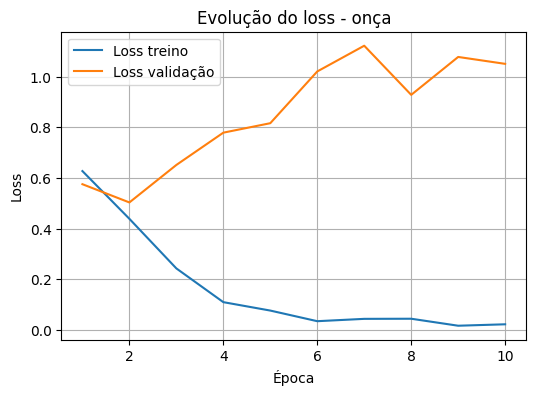

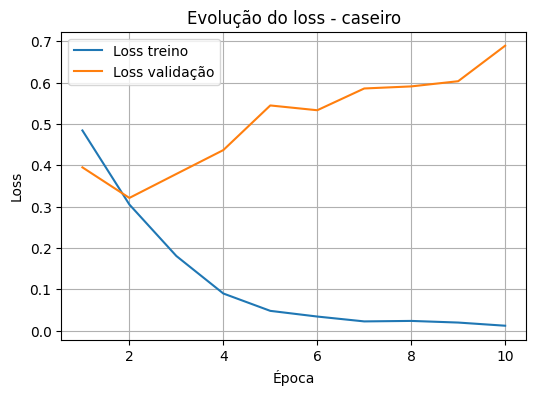

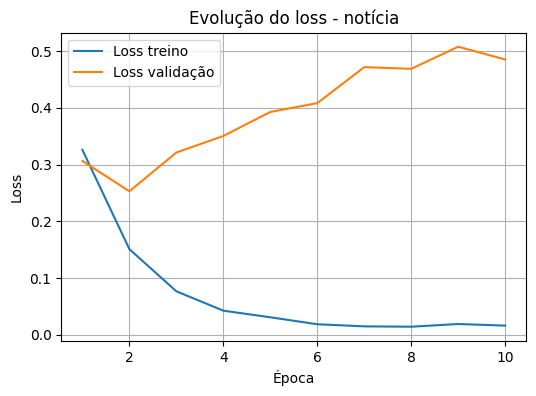

In [30]:
# 17. Gráficos de evolução do loss

import matplotlib.pyplot as plt

def plot_losses(result, titulo):
    epochs = range(1, len(result["train_losses"]) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, result["train_losses"], label="Loss treino")
    plt.plot(epochs, result["val_losses"], label="Loss validação")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"Evolução do loss - {titulo}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(result_onca, "onça")
plot_losses(result_caseiro, "caseiro")
plot_losses(result_noticia, "notícia")


## Mostrar Erros

In [31]:
# 18. Exemplos de erros no conjunto de teste

def mostrar_erros(coluna_rotulo, model, tokenizer, max_len=128, num_exemplos=5):
    """
    Gera o split novamente só para pegar o test_df,
    roda o modelo nesse teste e mostra alguns exemplos
    em que o modelo errou.
    """
    print(f"\n=== Exemplos de erros para a coluna: {coluna_rotulo} ===")

    # Refaz o split só para obter test_df
    _, _, test_df = preparar_dados_para_coluna(df, coluna_rotulo)

    textos = test_df["text"].tolist()
    verdadeiros = test_df["label_id"].tolist()

    preds = []
    model.eval()

    with torch.no_grad():
        for text in textos:
            enc = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            )

            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_id = outputs.logits.argmax(dim=1).item()
            preds.append(pred_id)

    # coleta erros
    erros = []
    for text, y_true, y_pred in zip(textos, verdadeiros, preds):
        if y_true != y_pred:
            erros.append((text, id2label[y_true], id2label[y_pred]))

    if not erros:
        print("Nenhum erro encontrado (isso é raro).")
        return

    for i, (text, real, pred) in enumerate(erros[:num_exemplos], start=1):
        print(f"\nExemplo {i}:")
        print(f"Texto  : {text}")
        print(f"Real   : {real}")
        print(f"Predito: {pred}")


# Chamadas para cada coluna
mostrar_erros("onca", model_onca, tokenizer, num_exemplos=5)
mostrar_erros("caseiro", model_caseiro, tokenizer, num_exemplos=5)
mostrar_erros("notícia", model_noticia, tokenizer, num_exemplos=5)



=== Exemplos de erros para a coluna: onca ===

=== Preparando dados para coluna: onca ===
Tamanho após limpeza: 4498

Distribuição de rótulos (texto):
label
neutro      3417
negativo     718
positivo     363
Name: count, dtype: int64

Distribuição de rótulos (ids):
label_id
1    3417
0     718
2     363
Name: count, dtype: int64

Tamanhos: 3148 treino  | 675 validação  | 675 teste

Exemplo 1:
Texto  : O ser humano foi criado pelo todo poderoso Deus,  os animais servem de alimento,  ñ o homem essa linha foi quebrada , tem q ser abatida, o homem está acima de tudo, só abaixo de Deus.
Real   : negativo
Predito: positivo

Exemplo 2:
Texto  : A onça estudou os passos do Sr. Jorge...
Real   : negativo
Predito: neutro

Exemplo 3:
Texto  : Acredito que os incêndios do último verão podem ter desequilibrado o ambiente,a ponto de faltarem alimentos para alguns animais,como onças,por exemplo.
Real   : positivo
Predito: neutro

Exemplo 4:
Texto  : ​@@DAVI-LDI Ainda prefiro a onça
Real   : positivo